# **Milestone 2 Phase 2**

Nama: Julio Putra David

Batch: 10

_______________________________

## **1. Introduction**

This notebook covers the establishment of Natural Language Processing using Deep Learning. The task is to do sentiment analysis of movie reviews on IMDB. The dataset is obtained from Kaggle with this following link: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?datasetId=134715

*Note: Please run this notebook in Google Colab and upload your kaggle.json to the session storage.*

## **2. Import Libraries**

In [63]:
# Basic Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pickle
from wordcloud import WordCloud, STOPWORDS

# Pre-processing Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords

# Deep Learning Algorithm Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GRU

# Model Evaluation Libraries
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Pipeline Libraries
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Warning Neglect Library
import warnings
warnings.filterwarnings('ignore')

## **3. Data Loading**

First we will draw our corpus from kaggle using the codes below.

In [2]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle 
!mkdir ./kaggle 
!mv ./kaggle.json ./kaggle 

!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# Download dataset
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

kaggle.json
 58% 15.0M/25.7M [00:00<00:00, 156MB/s]
100% 25.7M/25.7M [00:00<00:00, 188MB/s]


Since we only have 1 file in the .zip we don't have to unzip it.

In [3]:
df = pd.read_csv('imdb-dataset-of-50k-movie-reviews.zip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Make a copy of the original dataset

In [4]:
data = df.copy()

## **4. Exploratory Data Analysis (EDA)**

#### **1. Shape of Data**

In [5]:
r = data.shape[0]
c = data.shape[1]
print('Number of rows    =', r)
print('Number of columns =', c)

Number of rows    = 50000
Number of columns = 2


#### **2. Data Information**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


#### **3. Missing Values**

In [7]:
data.isnull().any()

review       False
sentiment    False
dtype: bool

There are no missing values in out dataset

#### **3. Class Proportion**

positive    25000
negative    25000
Name: sentiment, dtype: int64


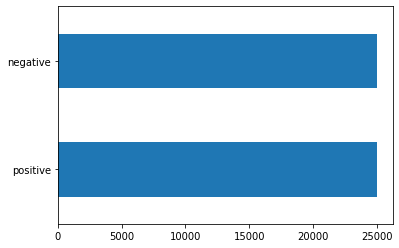

In [8]:
print(data.sentiment.value_counts())
data.sentiment.value_counts().plot(kind='barh')

We only have 2 sentiments, which are NEGATIVE and POSITIVE review. The data is **perfectly balanced**.

#### **4. Word Cloud**

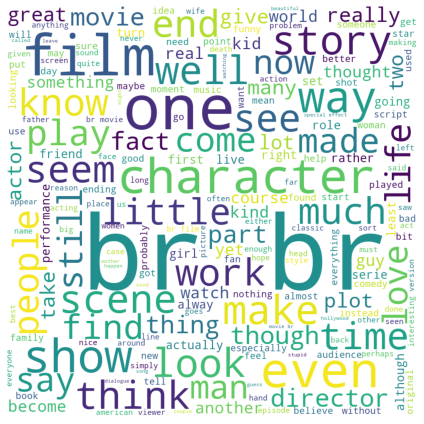

In [10]:
# Below is the codes for making wordcloud. Cited from https://www.geeksforgeeks.org/generating-word-cloud-python/
comment_words = ''
stopwords = set(STOPWORDS)
 
for i in data.review:
    i = str(i)
    tokens = i.split()

    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(comment_words)
                       
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()
 
plt.show()

The most frequent word is **br**. I'm not sure what br is, it is probably a slang.

#### **5. Duplicated Data**

In [11]:
data[data.duplicated()]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


It appears that we have 418 duplicated reviews here. Thus, we will drop it and we will check the balance again.

## **5. Data Pre-processing**

### **5.1 Feature Engineering**

Drop duplicated data

In [12]:
data.drop_duplicates(inplace = True)

In [13]:
data.shape

(49582, 2)

In [14]:
print(data.sentiment.value_counts())

positive    24884
negative    24698
Name: sentiment, dtype: int64


After the duplicated data are dropped, the target variable is still balanced.

Next we will convert the `sentiment` column into numerical form.

In [15]:
data['sentiment'] = data.sentiment.replace({'negative':0, 'positive':1})

Now we will remove the stopwords.

In [16]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['review'].sample(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


10109    I huge fan first four Ju-on projects. I them, ...
28448    I give 2, beautiful Mediterranean Greece, othe...
1193     I'd give film 1/10. This film devoid common ci...
40575    As good Schindler's List was, I found movie mu...
32541    I extremely picky films I see. I'd heard Moon ...
4248     If sons daughters love action, adventure, intr...
2253     The Twins Effect - Chinese Action/Comedy - (Ch...
35728    The Radar Men Moon pretty typical fare 1950's ...
21379    Yet ANOTHER movie group less-than-intelligent ...
43562    This disgrace game FarCry much expectations en...
Name: review, dtype: object

We can see from the series abovee the stopwords are removed. The grammatical structure are now messed up but that's okay.

### **5.2 Data Inference**

We will take out 10 samples to be our data inference.

In [17]:
data_inf = data.sample(10, random_state=77)

In [18]:
data.drop(data_inf.index, inplace=True)

We will reset the index to prevent unwanted errors.

In [19]:
data.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

### **5.3 Data Splitting**

We will split the data into train-set, validation-set, and test-set.

In [20]:
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=77, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=77, stratify=y_train)

### **5.4 Target Encoding**

We will encode the target variable using one-hot encoder.

In [22]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

### **5.5 Text Vectorization**

First we will count the number of non-zero element and number of vocab using CountVectorizer

In [23]:
vect = CountVectorizer()

X_train_vec = vect.fit_transform(X_train)
X_val_vec = vect.transform(X_val)
X_test_vec = vect.transform(X_test) 

In [24]:
X_train_vec

<37922x91264 sparse matrix of type '<class 'numpy.int64'>'
	with 4072596 stored elements in Compressed Sparse Row format>

In [25]:
round(sum([len(i.split()) for i in X_train]) / len(X_train))

136

We have 136 non-zero element and 91264 vocabs in our corpus.

Next we will setup the vectorization. We will use **75000** as our `max_vocab_length` and **136** as our `max_length`

In [27]:
# Setup Vectorization
max_vocab_length = 75000
max_length = 136

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_length,
                                       input_shape=(1,))                                       

Then we adapt the text vectorization to our X_train

In [28]:
text_vectorization.adapt(X_train)

## **6. Model Definition**

First we will define the Embedding layer.

In [49]:
embed_layer = Embedding(input_dim=max_vocab_length,
                        output_dim=150,
                        embeddings_initializer="uniform",
                        input_length=max_length
                       )

### **7.1 Fully Connected Layer**

Layers explanation:

* We will use Sequential API
* The input layer is defined in the Text Vectorization
* There are 3 hidden layers:
    * **Embedding Layer** for converting each word into a vector with a fixed length
    * **GlobalAveragePooling1D** to make `logits` and `labels` have the same shape
    * **Dense Layer** with 64 neurons, with activation function `elu`
* We will dropout 0.2 to prevent overfitting.
* Output layer is using `sigmoid` as the activation function
* The loss is `binary_croessentropy` because this is binary class classification task
* The optimizer that will be used is `adam` (The latest one)
* The metrics that will be monitored is `accuracy`

In [51]:
model_full = Sequential()

model_full.add(text_vectorization)
model_full.add(embed_layer)
model_full.add(Dropout(0.2))
model_full.add(GlobalAveragePooling1D())
model_full.add(Dense(64, activation='elu'))
model_full.add(Dropout(0.2))
model_full.add(Dense(2, activation='sigmoid'))

model_full.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

For our model improvement, we will try to use **GRU**.

### **7.2 GRU**

This model is aimed to improve the previous one.

Layers explanation:

* We will use Sequential API
* The input layer is defined in the Text Vectorization
* There are 2 hidden layers:
    * **Embedding Layer** for converting each word into a vector with a fixed length
    * **GRU layer** is used so the model does not use any non-useful information from the past. It hsa 36 neurons, the activation function is the default which is `tanh`
* We will use dropout to prevent overfitting
* Output layer is using `sigmoid` as the activation function
* The loss is `binary_croessentropy` because this is binary class classification task
* The optimizer that will be used is `adam` (The latest one)
* The metrics that will be monitored is `accuracy`

In [57]:
model_gru = Sequential()

model_gru.add(text_vectorization)
model_gru.add(embed_layer)
model_gru.add(Dropout(0.8))
model_gru.add(GRU(36))
model_gru.add(Dropout(0.8))
model_gru.add(Dense(2, activation='sigmoid'))


model_gru.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

## **7. Model Training**

### **7.1 Fully Connected Layer**

In [52]:
# Define callback
callback = EarlyStopping(monitor='val_accuracy', patience=3)

model_full_hist = model_full.fit(X_train,
                                 y_train_ohe,
                                 epochs=50,
                                 validation_data=(X_val, y_val_ohe),
                                 callbacks=[callback])

Epoch 1/50
1186/1186 [==============================] - 14s 11ms/step - loss: 0.3508 - accuracy: 0.8448 - val_loss: 0.2808 - val_accuracy: 0.8844
Epoch 2/50
1186/1186 [==============================] - 13s 11ms/step - loss: 0.1681 - accuracy: 0.9372 - val_loss: 0.3172 - val_accuracy: 0.8790
Epoch 3/50
1186/1186 [==============================] - 13s 11ms/step - loss: 0.0898 - accuracy: 0.9690 - val_loss: 0.4097 - val_accuracy: 0.8723
Epoch 4/50
1186/1186 [==============================] - 12s 10ms/step - loss: 0.0491 - accuracy: 0.9839 - val_loss: 0.5642 - val_accuracy: 0.8654


The training stopped at 4th epoch 

### **7.2 GRU**

In [58]:
model_gru_hist = model_gru.fit(X_train,
                               y_train_ohe,
                               epochs=50,
                               validation_data=(X_val, y_val_ohe),
                               callbacks=[callback])

Epoch 1/50
1186/1186 [==============================] - 20s 16ms/step - loss: 0.3239 - accuracy: 0.8774 - val_loss: 0.4890 - val_accuracy: 0.8552
Epoch 2/50
1186/1186 [==============================] - 18s 15ms/step - loss: 0.3110 - accuracy: 0.9002 - val_loss: 0.4140 - val_accuracy: 0.8318
Epoch 3/50
1186/1186 [==============================] - 18s 15ms/step - loss: 0.2323 - accuracy: 0.9433 - val_loss: 0.4675 - val_accuracy: 0.8626
Epoch 4/50
1186/1186 [==============================] - 18s 15ms/step - loss: 0.2635 - accuracy: 0.9207 - val_loss: 0.4559 - val_accuracy: 0.8574
Epoch 5/50
1186/1186 [==============================] - 18s 15ms/step - loss: 0.1440 - accuracy: 0.9656 - val_loss: 0.4944 - val_accuracy: 0.8638
Epoch 6/50
1186/1186 [==============================] - 18s 15ms/step - loss: 0.0805 - accuracy: 0.9789 - val_loss: 0.5231 - val_accuracy: 0.8721
Epoch 7/50
1186/1186 [==============================] - 18s 15ms/step - loss: 0.0526 - accuracy: 0.9842 - val_loss: 0.6896 -

The training stopped at 9th epoch. It took more epochs than the Fully Connected Layer.

## **8. Model Evaluation**

### **8.1 Fully Connected Layer**

Let's see the plot of train and validation loss

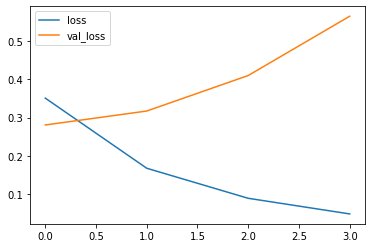

In [53]:
metrics_full = pd.DataFrame(model_full_hist.history)
metrics_full[['loss', 'val_loss']].plot()

Next we will see the plot of train and validation accuracy

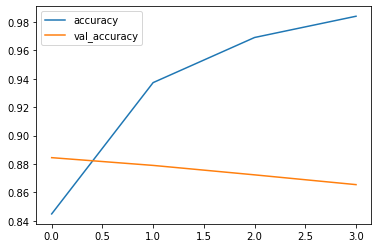

In [54]:
metrics_full[['accuracy', 'val_accuracy']].plot()

From the plot above we can see that the model is overfitted. 

In [55]:
y_pred_val_full = model_full.predict(X_val)
y_pred_val_full = y_pred_val_full.argmax(axis=1)
print(classification_report(y_val, y_pred_val_full))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2099
           1       0.85      0.89      0.87      2115

    accuracy                           0.87      4214
   macro avg       0.87      0.87      0.87      4214
weighted avg       0.87      0.87      0.87      4214



In [56]:
y_test_val_full = model_full.predict(X_val)
y_test_val_full = y_test_val_full.argmax(axis=1)
print(classification_report(y_val, y_test_val_full))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2099
           1       0.85      0.89      0.87      2115

    accuracy                           0.87      4214
   macro avg       0.87      0.87      0.87      4214
weighted avg       0.87      0.87      0.87      4214



**Evaluation results:**

*   The accuracy is **0.87** which is good, that means out prediction is **87% correct**.
*   The precision is **0.89** which is good, that means we predicted **89% of the positive class that has been predicted are correct**.
*   The recall is **0.84** which is also good, that means we predicted **84% of the positive class corrrectly**.







### **8.2 GRU**

Now let's see how our model improves after using **GRU**.

Let's see the plot of train and validation loss

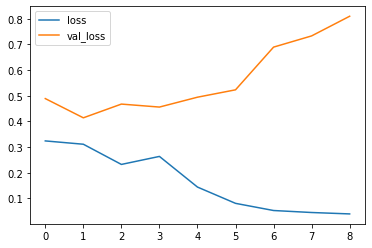

In [59]:
metrics_gru = pd.DataFrame(model_gru_hist.history)
metrics_gru[['loss', 'val_loss']].plot()

Next we will see the plot of train and validation accuracy

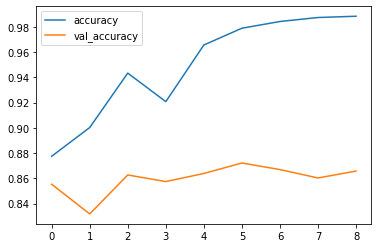

In [60]:
metrics_gru[['accuracy', 'val_accuracy']].plot()

From the plot above we can see that the model is overfitted. But if we take a look at the epochs result, the gap between train score and val score is not that far.

In [61]:
y_pred_val_gru = model_gru.predict(X_val)
y_pred_val_gru = y_pred_val_gru.argmax(axis=1)
print(classification_report(y_val, y_pred_val_gru))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2099
           1       0.86      0.87      0.87      2115

    accuracy                           0.87      4214
   macro avg       0.87      0.87      0.87      4214
weighted avg       0.87      0.87      0.87      4214



In [62]:
y_pred_test_gru = model_gru.predict(X_test)
y_pred_test_gru = y_pred_test_gru.argmax(axis=1)
print(classification_report(y_test, y_pred_test_gru))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3704
           1       0.86      0.89      0.87      3732

    accuracy                           0.87      7436
   macro avg       0.87      0.87      0.87      7436
weighted avg       0.87      0.87      0.87      7436



**Evaluation results:**

*   The accuracy is **0.87** which is good, that means out prediction is **87% correct**.
*   The precision is **0.88** which is good, that means we predicted **88% of the positive class that has been predicted are correct**.
*   The recall is **0.86** which is also good, that means we predicted **84% of the positive class corrrectly**.

The recall is improved.

Considering all metrics, we will choose `GRU` for our deployment.

## **9. Model Saving**

We will save the model that will be trained using Tensorflow pipeline first.

In [65]:
# Define pipeline for train, val, and test set
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe))
train_set = train_set.batch(50)

val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val_ohe))
val_set = val_set.batch(50)

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test_ohe))
test_set = test_set.batch(50)

# Define the model_pipe
model_pipe = Sequential()
model_pipe.add(text_vectorization)
model_pipe.add(embed_layer)
model_pipe.add(Dropout(0.8))
model_pipe.add(GRU(36))
model_pipe.add(Dropout(0.8))
model_pipe.add(Dense(2, activation='sigmoid'))

model_pipe.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'],
                   )

model_pipe.fit(train_set, epochs=50, validation_data=val_set, callbacks=[callback])

Epoch 1/50
759/759 [==============================] - 14s 16ms/step - loss: 0.4253 - accuracy: 0.8309 - val_loss: 0.5395 - val_accuracy: 0.8344
Epoch 2/50
759/759 [==============================] - 12s 16ms/step - loss: 0.3780 - accuracy: 0.8602 - val_loss: 0.5203 - val_accuracy: 0.8372
Epoch 3/50
759/759 [==============================] - 12s 16ms/step - loss: 0.2053 - accuracy: 0.9514 - val_loss: 0.5239 - val_accuracy: 0.8493
Epoch 4/50
759/759 [==============================] - 12s 16ms/step - loss: 0.1809 - accuracy: 0.9570 - val_loss: 0.5814 - val_accuracy: 0.8529
Epoch 5/50
759/759 [==============================] - 12s 16ms/step - loss: 0.1475 - accuracy: 0.9705 - val_loss: 0.7400 - val_accuracy: 0.8268
Epoch 6/50
759/759 [==============================] - 12s 16ms/step - loss: 0.1353 - accuracy: 0.9723 - val_loss: 0.6016 - val_accuracy: 0.8593
Epoch 7/50
759/759 [==============================] - 12s 16ms/step - loss: 0.0944 - accuracy: 0.9824 - val_loss: 0.6049 - val_accuracy:

In [66]:
model_pipe.save('imdb_model')

INFO:tensorflow:Assets written to: imdb_model/assets


INFO:tensorflow:Assets written to: imdb_model/assets


We will zip the folder so that it can be downloaded to our local storage.

In [67]:
!zip -r /content/Model.zip /content/imdb_model

  adding: content/imdb_model/ (stored 0%)
  adding: content/imdb_model/assets/ (stored 0%)
  adding: content/imdb_model/keras_metadata.pb (deflated 87%)
  adding: content/imdb_model/saved_model.pb (deflated 74%)
  adding: content/imdb_model/variables/ (stored 0%)
  adding: content/imdb_model/variables/variables.index (deflated 59%)
  adding: content/imdb_model/variables/variables.data-00000-of-00001 (deflated 19%)


In [68]:
from google.colab import files
files.download('/content/Model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After we download the model as zip, we will unzip it and use it for model deployment using **Streamlit**

## **10. Model Inference**

In our model inference, we will not do stopwords removal anymore because it has been done before the data was splitted.

First we load our model

In [71]:
model_inf = tf.keras.models.load_model('imdb_model')

Then we do the prediction using the model

In [ ]:
y_pred_inf = model_inf.predict(data_inf['review'])
y_pred_inf = y_pred_inf.argmax(axis=1)
y_pred_inf

Now we want to see if the sentiment prediction matches the content of the movie review

In [75]:
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['pred-sentiment'])

In [83]:
data_inf_pred = data_inf[['review']]
data_inf_pred['pred-sentiment'] = y_pred_inf_df
data_inf_pred

,review,pred-sentiment
0,The movie would included Mystery Science Theat...,0
1,"The Brothers Quay directors, judging conventio...",0
2,"This film clever, witty often heart touching m...",1
3,This movie *good* relatively first parts it.<b...,0
4,And I absolutely adore Isabelle Blais!!! She c...,1
5,"A pre-Nerd Robert Carradine, pre-Automan Desi ...",0
6,A lot comments people made strike (sorry) miss...,1
7,"The '80's best times worst times James Karin, ...",0
8,Fado sad almost bluesy style Portuguese Gypsy ...,0
9,"I right watching ""The Big Chill"" DVD. One acto...",1


The prediction is quite good.

## **11. Conclusion**

NLP is a highly challenging task that is really useful. In this case, we have just make a prediction for analyzing the sentiment of movie review, whether it is a positive or negative review.

We used two algorithm, which are the RNN with Fully Connected Layer, and Gated Recurrent Unit (GRU). Both algorithms performed really well, the precision, recall, and accuracy are good. However, the model is a bit overfitted. The metrics score between the Fully Connected Layer and GRU are only slightly different in precision and recall. Fully Connected Layer has higher precision with the difference of 0.1, and GRU has higher recall with the difference of 0.2. Thus, I chose GRU for the deployment.

The final metrics scores are: 

   **Accuracy    : 0.87**

   **Precision   : 0.88**

   **Recall      : 0.86**

The scores are pretty good.

The pre-processing methods that are applicable for this case was text vectorization that includes case folding and punctuation removal, and stopwords removal. I have tried to use stemming but the accuracy was not good so I decided to not use it. 

We have also tried our model using new data in the Model Inference section, and if we read the review, the predicted sentiment is quite correct.

To sum up, both Fully Connected Layer and GRU are powerful model for NLP. I recommend to always try to compare them both in doing NLP tasks.